#### Load Necessary Libraries

In [ ]:
import os
import sys
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from skimage import color, io
import cv2
from PIL import Image
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage

from IPython.display import Video

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Image Compression using SVD

In this section, we will use the Singular Value Decomposition (SVD) to compress images. To do this, we will first convert an image to grayscale. We will then convert the image to a matrix of doubles. We will then use the SVD to approximate the image matrix by a matrix of lower rank. We will then use the approximation to compress the image.


## Compression Phase

To begin, we will load an image and convert it to grayscale. We will then convert the image to a matrix of doubles. The values in this matrix range from 0 to 255, where 0 represents black and 255 represents white. We will then use the SVD to approximate the image matrix by a matrix of lower rank. We will then use the approximation to compress the image.

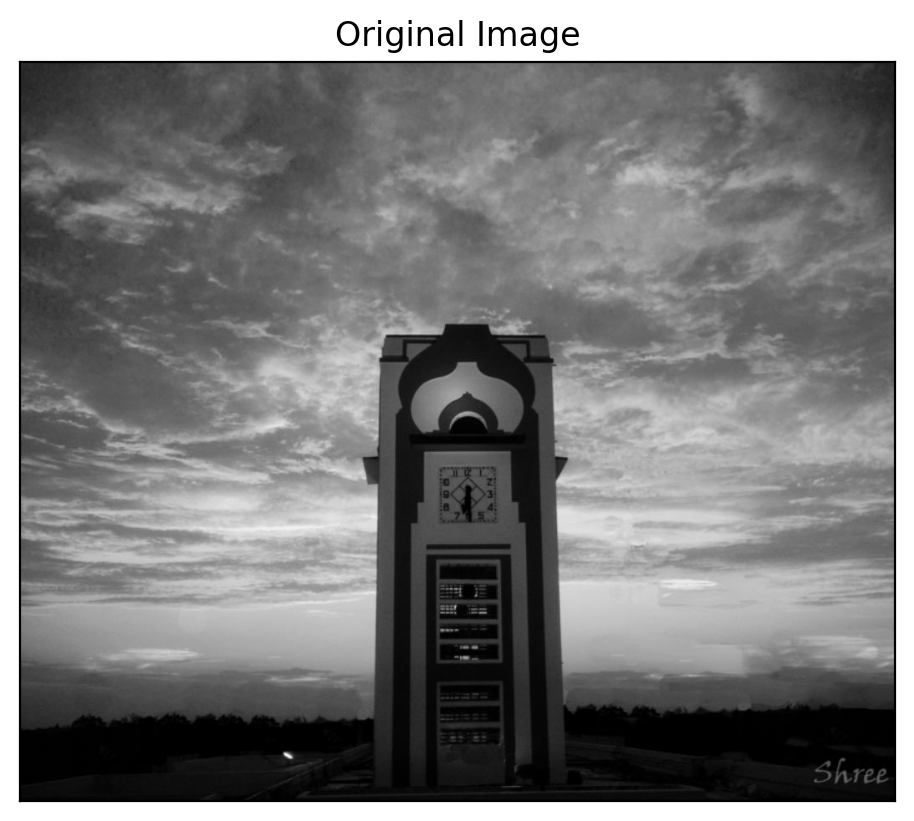

In [ ]:
def load_and_preprocess_image(image_path):
    # Load the image in grayscale with cv2
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Ensure the image is loaded successfully
    if original_image is None:
        raise ValueError("Image not found or cannot be loaded.")

    # Convert the image to a matrix of doubles
    image_matrix = original_image.astype(np.float64)

    return image_matrix

# Replace 'path_to_image' with the actual image path
image_path = 'image1.jpg'
image = load_and_preprocess_image(image_path)

# Display the original image
plt.imshow(image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()


### Applying SVD on Image
We apply Singular Value Decomposition (SVD) on the image. We only keep the first 'k' singular values, which represent the most significant features of the image. This step compresses the image by reducing the amount of data needed to represent it.


In [165]:
def apply_svd(image):
    # Apply SVD to the image
    U, s, Vt = np.linalg.svd(image, full_matrices=False)

    return U, s, Vt.T


U, s, V = apply_svd(image)

(884, 884) (884,) (1046, 884)


#### Choosing the number of singular values to keep

The number of singular values to keep is a hyperparameter. The higher the number of singular values kept, the higher the quality of the image. However, the higher the number of singular values kept, the higher the size of the image. The number of singular values to keep is a trade-off between image quality and image size. To choose the number of singular values to keep, we can use the concept of the explained variance ratio. The explained variance ratio is the ratio of the variance explained by a singular value to the total variance. The explained variance ratio is a measure of the amount of information retained by a singular value. The explained variance ratio is calculated as follows:

$$
var_k = \frac{\sum_{i=1}^{k} \sigma_i^2}{\sum_{i=1}^{n} \sigma_i^2}
$$

where $var_k$ is the explained variance ratio, $\sigma_i$ is the $i^{th}$ singular value, and $n$ is the total number of singular values. The explained variance ratio is a measure of the amount of information retained by a singular value. A good heuristic for choosing the number of singular values to keep is to choose the smallest number of singular values that explain a certain percentage of the total variance. For example, if we want to keep 90% of the total variance, we can choose the smallest number of singular values that explain 90% of the total variance.


In [ ]:
def choose_svd_components(image, threshold=0.9):

    _, s, _ = np.linalg.svd(image, full_matrices=False)
    explained_var_ratio = np.cumsum(s**2) / np.sum(s**2)
    num_components = np.argmax(explained_var_ratio >= threshold) + 1

    return num_components

variance_threshold = 0.99958

# choose the number of singular values to keep
k = choose_svd_components(image, variance_threshold)
print('Number of singular values to keep:', k)


Number of singular values to keep: 92


### Reconstruction Phase
After applying SVD on the image, we reconstruct the image using the reduced number of singular values.

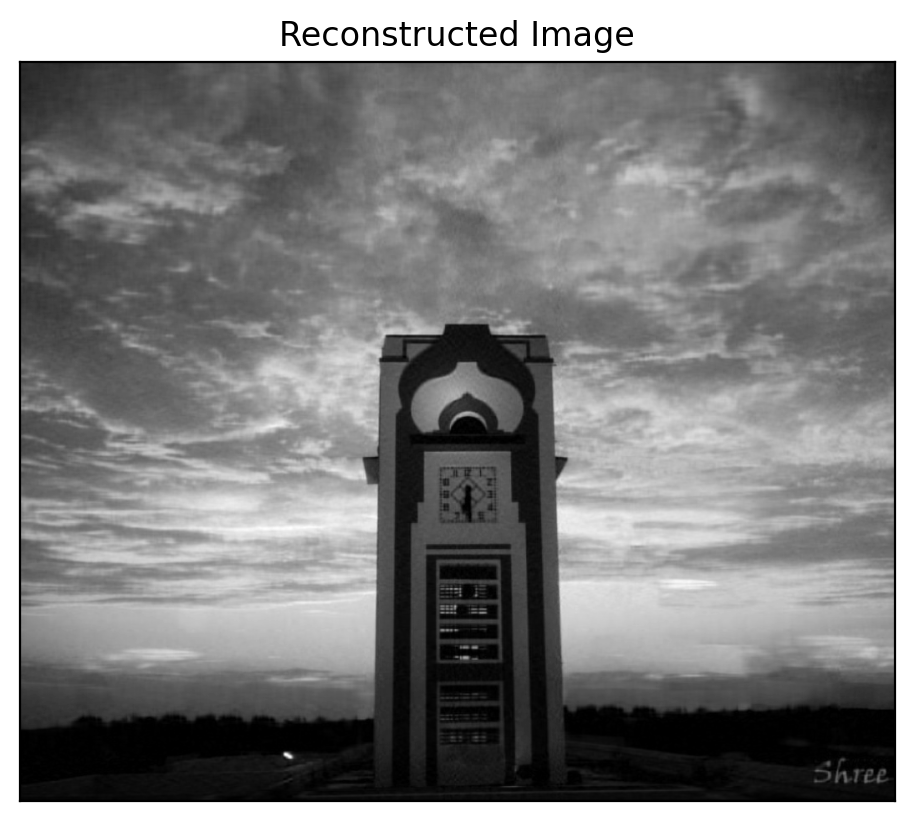

In [ ]:

def reconstruct_image(U, s, V, k):
    # Keep only the first 'k' singular values
    U_k = U[:, :k]
    s_k = np.diag(s[:k])
    Vt_k = V.T[:k, :]

    # Reconstruct the compressed image
    compressed_image = U_k @ s_k @ Vt_k

    return compressed_image


reconstructed_image = reconstruct_image(U, s, V, k)
plt.imshow(np.abs(reconstructed_image), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Reconstructed Image')
plt.show()

# Video Background Removal

In this part, you are supposed to separate the background and foreground of a video using SVD.

In [119]:
video = mpy.VideoFileClip('video.mp4')
# video.subclip(0, 50).ipython_display(width=500)
video.ipython_display(width=500)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [152]:
def resize_frame(frame, scale):
    # If the frame is 3D (RGB), convert it to grayscale
    if len(frame.shape) == 3:
        frame = rgb2grey(frame)

    # Convert the NumPy array to a PIL Image
    img = Image.fromarray(frame.astype('uint8'), 'L')  # 'L' for grayscale

    # Resize the image
    new_size = (int(img.size[0] * scale / 100), int(img.size[1] * scale / 100))
    img_resized = img.resize(new_size)

    # Convert the PIL Image back to a NumPy array
    frame_resized = np.array(img_resized)

    return frame_resized



def create_data_matrix_from_video(clip, k, scale):
    frames = []
    for i in range(k * int(clip.duration)):
        # get the frame at time i
        frame = clip.get_frame(i / k)

        # convert the frame to grayscale
        frame_gray = rgb2grey(frame)

        # resize the frame
        frame_resized = resize_frame(frame_gray, scale)

        frames.append(frame_resized.flatten())
    # stack frames horizontally
    return np.vstack(frames).transpose()


def rgb2grey(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

In [153]:
# change resolution of image
# scale to X percent (100 means no scaling). CHANGE THIS FOR BETTER RESOLUTION
scale = 100
original_width = video.size[1]
original_height = video.size[0]

dims = (int(original_width * scale / 100), int(original_height * scale / 100))
dims  # single frame dimensions (height x width)

(240, 320)

In [155]:
fps = 20
M = create_data_matrix_from_video(video, fps, scale)
np.save('data/video_matrix', M)
M.shape, dims

((76800, 1000), (240, 320))

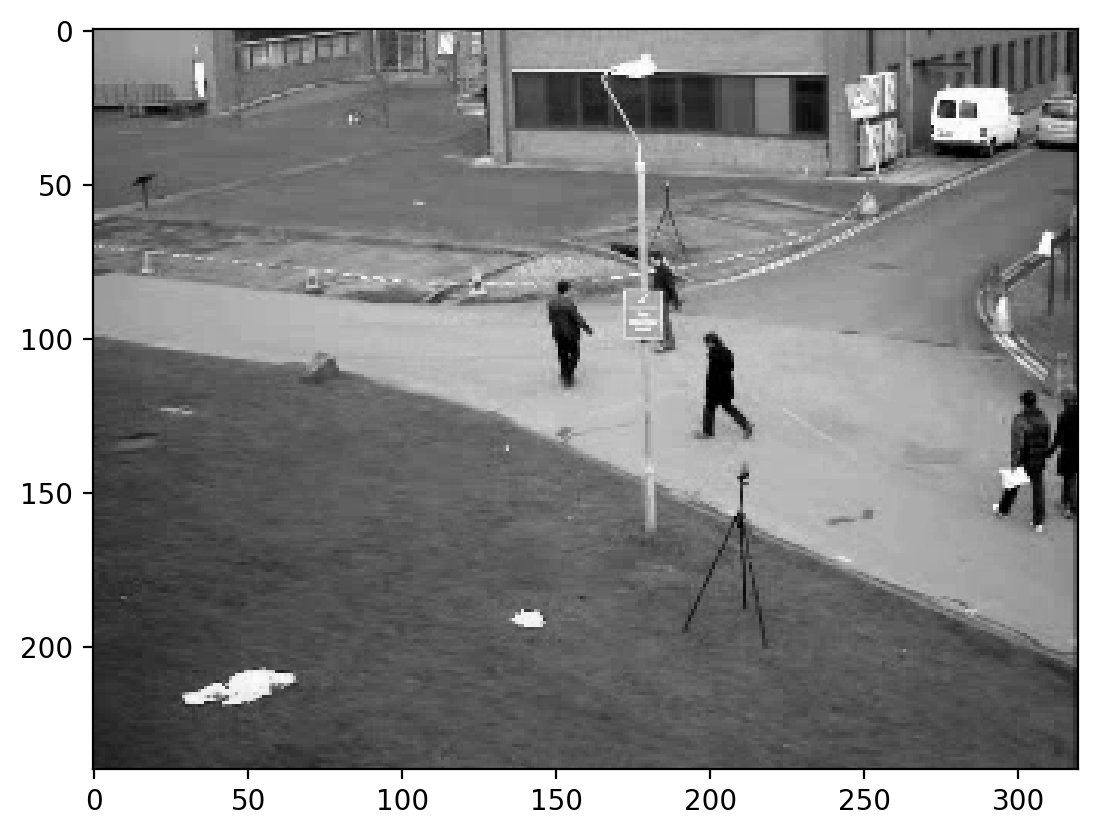

In [156]:
test_image = M[:, 50].reshape(dims)
plt.imshow(test_image, cmap='gray')
plt.show()

In [167]:
k = 20
U, s, Vh = apply_svd(M.T)
# Apply SVD to the data matrix
print(U.shape, s.shape, Vh.shape)

(1000, 1000) (1000,) (76800, 1000)


In [179]:
# calculate foreground from difference between original and reconstructed image
recons = reconstruct_image(U, s, Vh, k)

foreground_frames = recons.T - M


(1000, 76800)
(76800, 1000)



t:  20%|█▉        | 238/1200 [00:33<01:39,  9.67it/s, now=None]

t:  12%|█▏        | 141/1200 [00:13<02:38,  6.68it/s, now=None]

Moviepy - Building video data/people.mp4.
Moviepy - Writing video data/people.mp4





t:   0%|          | 0/1000 [00:00<?, ?it/s, now=None]

t:   0%|          | 3/1000 [00:00<00:54, 18.39it/s, now=None]

t:   0%|          | 5/1000 [00:00<01:02, 16.05it/s, now=None]

t:   1%|          | 7/1000 [00:00<01:04, 15.42it/s, now=None]

t:   1%|          | 9/1000 [00:00<01:04, 15.25it/s, now=None]

t:   1%|          | 11/1000 [00:00<01:05, 15.02it/s, now=None]

t:   1%|▏         | 13/1000 [00:00<01:09, 14.23it/s, now=None]

t:   2%|▏         | 15/1000 [00:00<01:07, 14.63it/s, now=None]



t:   2%|▏         | 19/1000 [00:01<01:21, 12.01it/s, now=None]

t:   2%|▏         | 21/1000 [00:01<01:16, 12.78it/s, now=None]

t:   2%|▏         | 23/1000 [00:01<01:12, 13.44it/s, now=None]

t:   2%|▎         | 25/1000 [00:01<01:11, 13.55it/s, now=None]

t:   3%|▎         | 27/1000 [00:01<01:10, 13.88it/s, now=None]

t:   3%|▎         | 29/1000 [00:02<01:07, 14.33it/s, now=None]

t:   3%|▎         | 31/1000 [00:02<01:06, 14.49it/s, now=None]

t:   3%|▎         | 33/1000 [00:02<01:08, 14.06it

Moviepy - Done !
Moviepy - video ready data/people.mp4


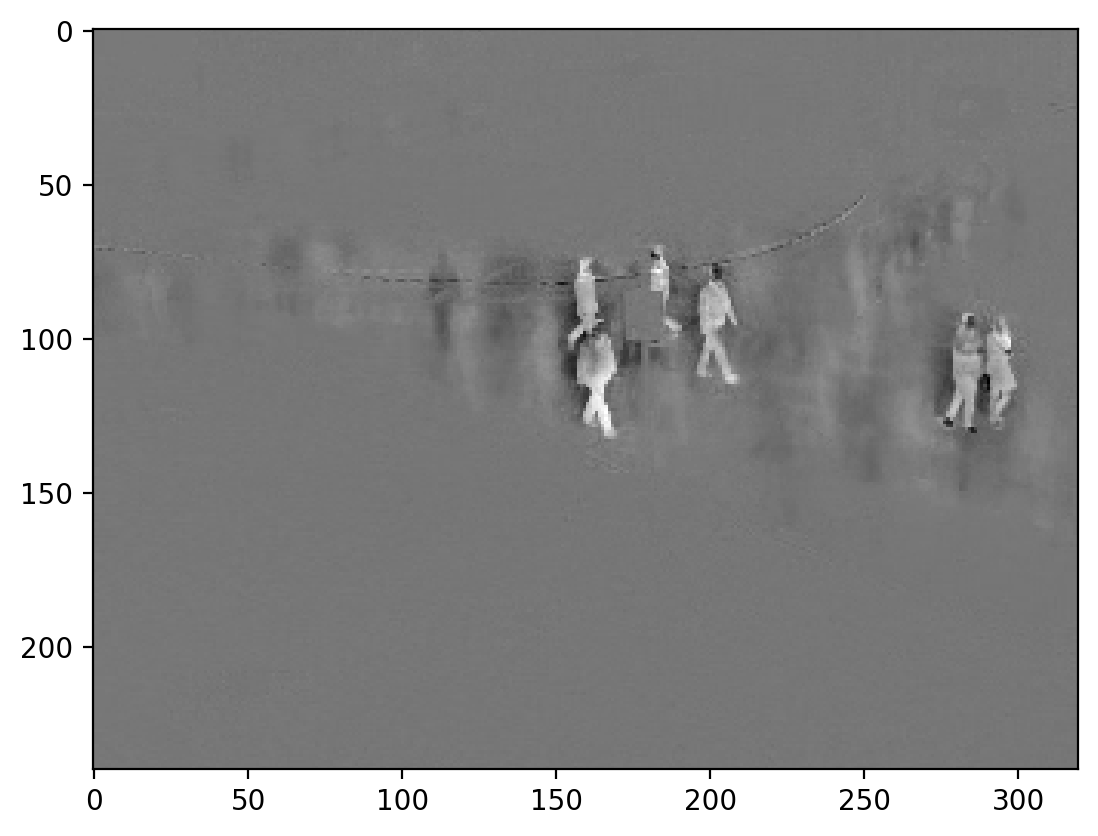

In [191]:
foreground_frames = foreground_frames.reshape((dims[0], dims[1], -1))
# print(foreground_frames.shape)
fig, ax = plt.subplots()


def make_frame(t):
    ax.clear()
    ax.imshow(foreground_frames[..., int(t*fps)], cmap='gray')
    return mplfig_to_npimage(fig)

from moviepy.editor import VideoClip
animation_clip = VideoClip(make_frame, duration=50)
animation_clip.write_videofile("data/people.mp4", fps=20)

# save video with gray color